In [5]:
import pandas as pd

import numpy as np
from sklearn.neighbors import NearestNeighbors

# Load dataset
df = pd.read_csv('../data_csv/customer_neighbors.csv') 
df = df.dropna()

# Convert latitude and longitude to radians
coords = np.radians(df[['latitude', 'longitude']])

# Fit kNN model (k=5 is typical, adjust as needed)
k = 20
nbrs = NearestNeighbors(n_neighbors=k+1,  # +1 to include the point itself
                        algorithm='ball_tree',
                        metric='haversine').fit(coords)

# Compute distances
distances, indices = nbrs.kneighbors(coords)

# Skip the first column (distance to self = 0), convert from radians to kilometers
avg_distances = distances[:, 1:].mean(axis=1) * 6371  # Earth's radius in km

# Add to DataFrame
df['avg_neighbor_distance_km'] = avg_distances
df.head(20)
df = df[['customer_unique_id', 'avg_neighbor_distance_km']]
df.head(20)


,customer_unique_id,avg_neighbor_distance_km
0,861eff4711a542e4b93843c6dd7febb0,0.468284
1,290c77bc529b7ac935b93aa66c333dc3,0.090499
2,060e732b5b29e8181a18229c7b0b2b5e,0.124451
3,259dac757896d24d7702b9acbbff3f3c,0.811154
4,345ecd01c38d18a9036ed96c73b8d066,0.000000
5,4c93744516667ad3b8f1fb645a3116a4,1.229255
6,addec96d2e059c80c30fe6871d30d177,0.010349
7,57b2a98a409812fe9618067b6b8ebe4f,2.201507
8,1175e95fb47ddff9de6b2b06188f7e0d,0.250733
9,9afe194fb833f79e300e37e580171f22,0.000000


In [138]:
# current best model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

machine_learning = pd.read_csv('../data_csv/machine_learning_1.csv')
machine_learning = machine_learning.merge(
    df[['customer_unique_id', 'avg_neighbor_distance_km']],
    on='customer_unique_id',
    how='left'
)
# Create interaction feature: freight value divided by product weight
machine_learning['freight_per_weight'] = machine_learning.apply(
    lambda row: row['freight_value'] / row['total_order_weight'] if row['total_order_weight'] > 0 and pd.notnull(row['total_order_weight']) else np.nan,
    axis=1
)

# Include the new features in the feature set
features = ['unique_seller_count', 'delivery_time_buffer', 'product_count',  'estimate_length', 'freight_value', 'freight_per_weight', 'price', 'distance', 'category', 'same_state',  'avg_neighbor_distance_km']
X = pd.get_dummies(machine_learning[features].dropna(), columns=[ 'category'])
y = machine_learning.loc[X.index, 'late']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

y_pred_proba = clf.predict_proba(X_test)[:, 1]



# Note, adding the customer and seller states may add too many features and lowers model performance
# perhaps, we can change the customer state to regional columns.

Accuracy: 0.9380093007380861

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     21601
           1       0.96      0.22      0.36      1838

    accuracy                           0.94     23439
   macro avg       0.95      0.61      0.66     23439
weighted avg       0.94      0.94      0.92     23439



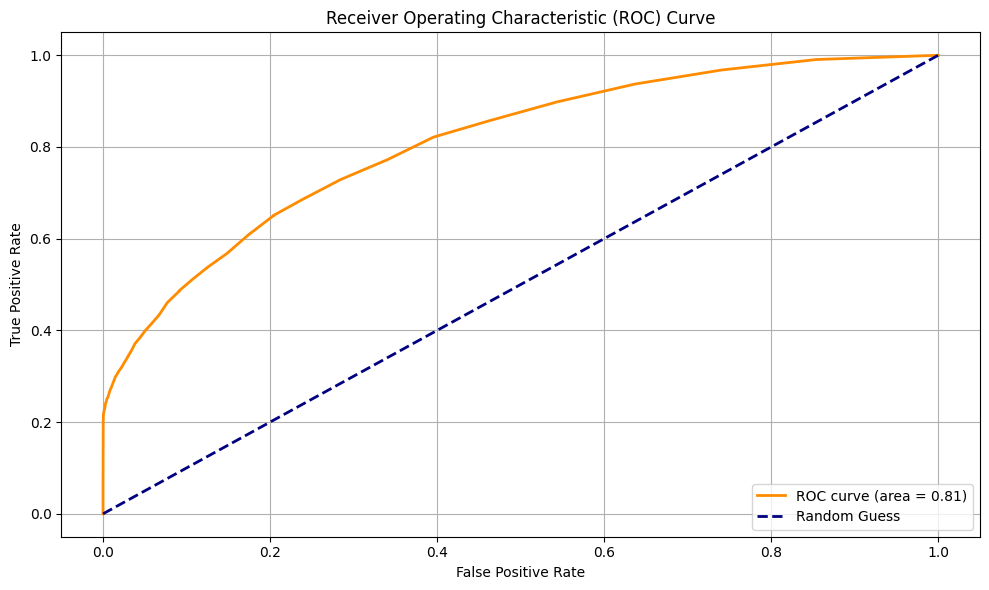

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

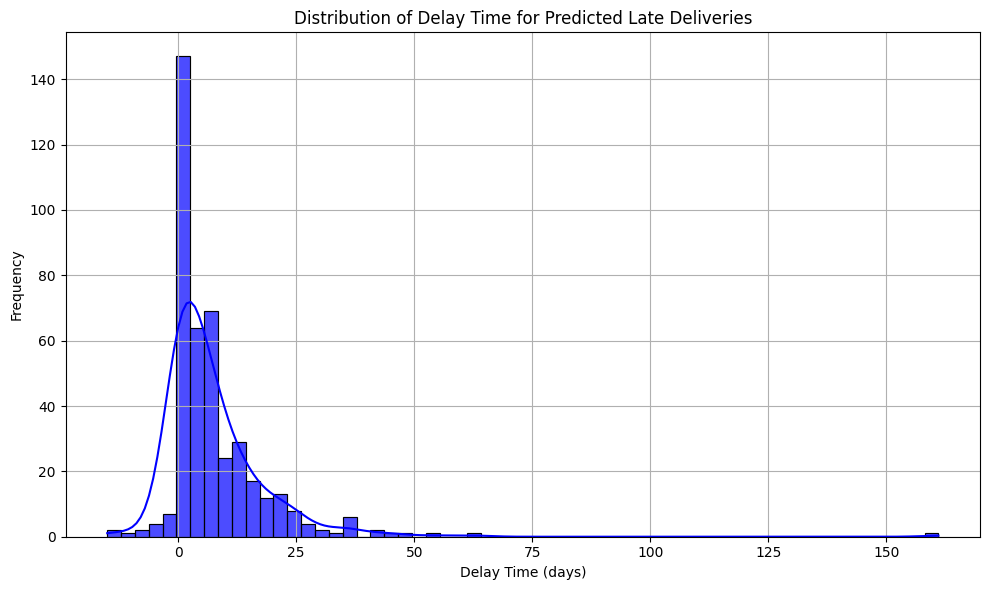

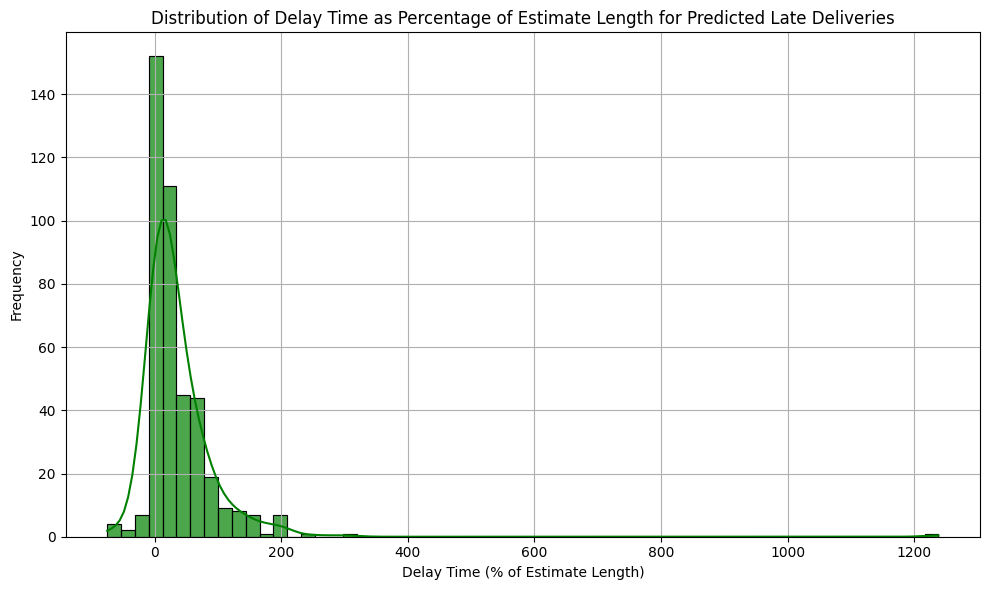

,customer_unique_id,delay_time,unique_seller_count,delivery_time_buffer,product_count,total_order_weight,seller_state,customer_state,route,estimate_length,...,product_weight_g,price,distance,category,late,same_state,same_city,avg_neighbor_distance_km,freight_per_weight,delay_percentage
60612,4546caea018ad8c692964e3382debd19,3,1,5,3,17000.0,SP,SP,SPSP,11,...,800.0,1.20,38.505499,health_beauty,1,1,1,0.249905,0.000464,27.272727
71430,3f1ae9854823f7c0a8027bd994b2ce64,15,1,6,1,2400.0,RJ,MG,RJMG,21,...,1200.0,69.90,161.234798,health_beauty,1,0,0,2.032876,0.006329,71.428571
69470,df946ef265626b1e0a425292815ddead,1,1,9,1,150.0,SP,SP,SPSP,12,...,150.0,18.99,48.651543,health_beauty,1,1,0,0.251691,0.051867,8.333333
45198,0e730550dfc5d7f1cea73484bb2e0249,15,1,6,1,700.0,SP,RJ,SPRJ,20,...,700.0,59.00,781.138690,furniture_decor,1,0,0,0.414367,0.023100,75.000000
90297,fb22cab15a8656528c3d36648860c9bc,14,1,12,1,39600.0,SP,SP,SPSP,14,...,13200.0,99.00,56.020032,furniture_decor,1,1,0,0.090912,0.000832,100.000000


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# want to see the delay distribution for those that were predicted. How much to extend the duration?
# in days and in percentage
# Filter the dataframe where y_pred is 1
y_pred_proba = clf.predict_proba(X_test)[:, 1]
predicted_late_df = X_test[y_pred == 1]


# Get the customer_unique_id for these predictions
predicted_late_df_full = machine_learning.loc[predicted_late_df.index]

plt.figure(figsize=(10, 6))
sns.histplot(predicted_late_df_full['delay_time'], bins=60, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Delay Time for Predicted Late Deliveries')
plt.xlabel('Delay Time (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate delay time as a percentage of estimate length
predicted_late_df_full['delay_percentage'] = (predicted_late_df_full['delay_time'] / predicted_late_df_full['estimate_length']) * 100

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(predicted_late_df_full['delay_percentage'], bins=60, kde=True, color='green', alpha=0.7)
plt.title('Distribution of Delay Time as Percentage of Estimate Length for Predicted Late Deliveries')
plt.xlabel('Delay Time (% of Estimate Length)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

predicted_late_df_full.head()


In [9]:
predicted_late_df_full
percentiles = predicted_late_df_full['delay_time'].quantile([0.05, 0.25, 0.5, 0.75, 0.9])
print(percentiles)

0.05     0.0
0.25     1.0
0.50     5.0
0.75    11.0
0.90    20.0
Name: delay_time, dtype: float64


In [142]:
# Filter rows where y_pred_proba is above a threshold
high_proba_indices = y_pred_proba > 0.3
low_proba_indices = y_pred_proba < 0.005
# Count the number of true positives and false positives
true_positives = ((y_test == 1) & high_proba_indices).sum()
false_positives = ((y_test == 0) & high_proba_indices).sum()

true_negatives = ((y_test == 0) & low_proba_indices).sum()
false_negatives = ((y_test == 1) & low_proba_indices).sum()

print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Negatives: {false_negatives}")
false_negative_percentage = (false_negatives / (false_negatives + true_negatives)) * 100
false_positive_percentage = (false_positives / (false_positives + true_positives)) * 100
print(f"Percentage of False Negatives among all negative predictions: {false_negative_percentage:.2f}%")
print(f"Percentage of False Positives among all positive predictions: {false_positive_percentage:.2f}%")

True Positives: 506
False Positives: 213
True Negatives: 3146
False Negatives: 17
Percentage of False Negatives among all negative predictions: 0.54%
Percentage of False Positives among all positive predictions: 29.62%


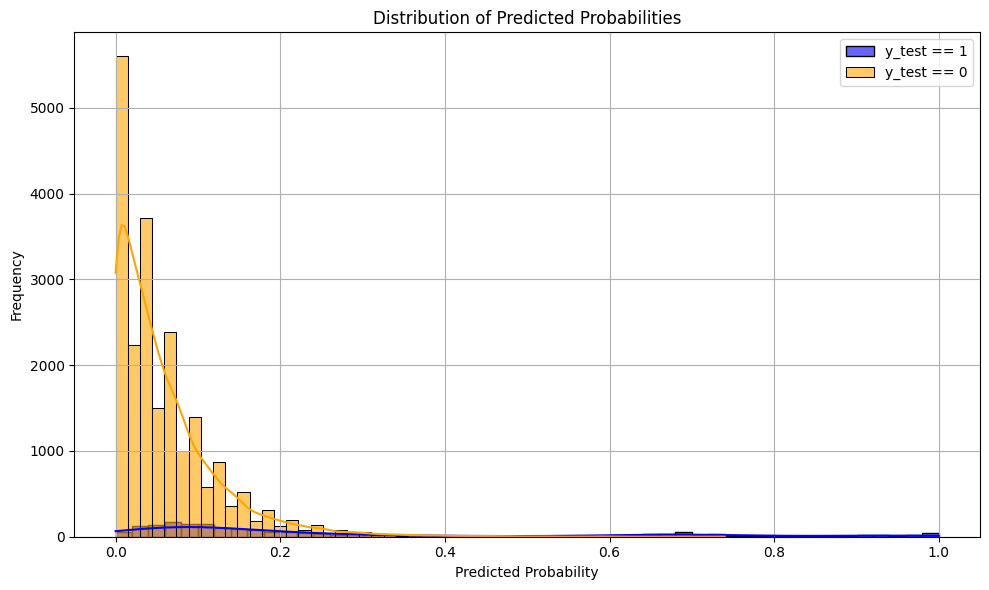

In [11]:
plt.figure(figsize=(10, 6))

# Plot distribution for y_test == 1
sns.histplot(y_pred_proba[y_test == 1], bins=50, kde=True, color='blue', alpha=0.6, label='y_test == 1')

# Plot distribution for y_test == 0
sns.histplot(y_pred_proba[y_test == 0], bins=50, kde=True, color='orange', alpha=0.6, label='y_test == 0')

plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

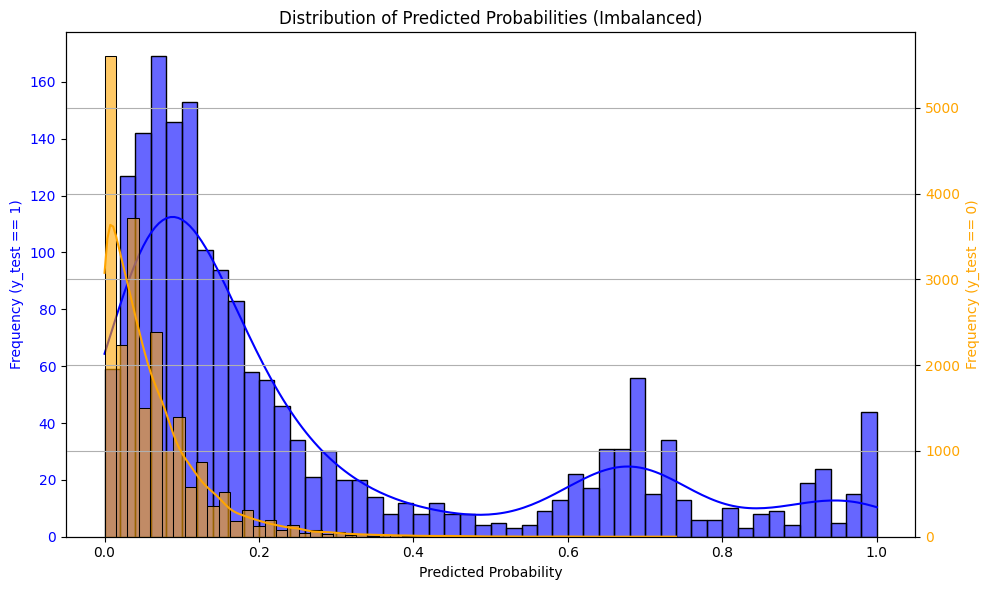

In [108]:
plt.figure(figsize=(10, 6))

# Create the first axis
ax1 = plt.gca()
sns.histplot(y_pred_proba[y_test == 1], bins=50, kde=True, color='blue', alpha=0.6, label='y_test == 1', ax=ax1)
ax1.set_ylabel('Frequency (y_test == 1)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second axis
ax2 = ax1.twinx()
sns.histplot(y_pred_proba[y_test == 0], bins=50, kde=True, color='orange', alpha=0.6, label='y_test == 0', ax=ax2)
ax2.set_ylabel('Frequency (y_test == 0)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and labels
plt.title('Distribution of Predicted Probabilities (Imbalanced)')
ax1.set_xlabel('Predicted Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

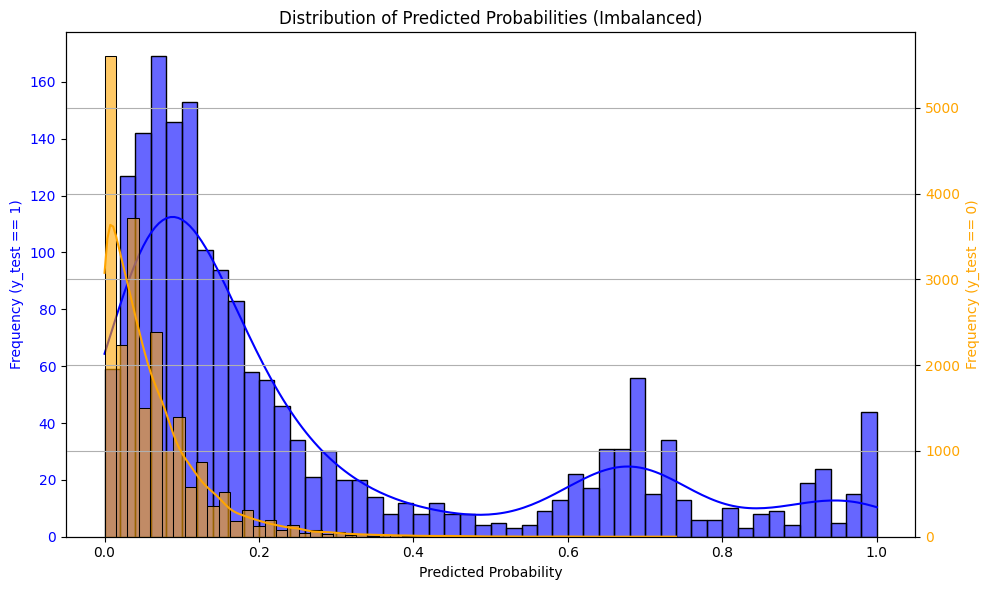

In [107]:
plt.figure(figsize=(10, 6))

# Create the first axis
ax1 = plt.gca()
sns.histplot(y_pred_proba[y_test == 1], bins=50, kde=True, color='blue', alpha=0.6, label='y_test == 1', ax=ax1)
ax1.set_ylabel('Frequency (y_test == 1)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second axis
ax2 = ax1.twinx()
sns.histplot(y_pred_proba[y_test == 0], bins=50, kde=True, color='orange', alpha=0.6, label='y_test == 0', ax=ax2)
ax2.set_ylabel('Frequency (y_test == 0)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and labels
plt.title('Distribution of Predicted Probabilities (Imbalanced)')
ax1.set_xlabel('Predicted Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

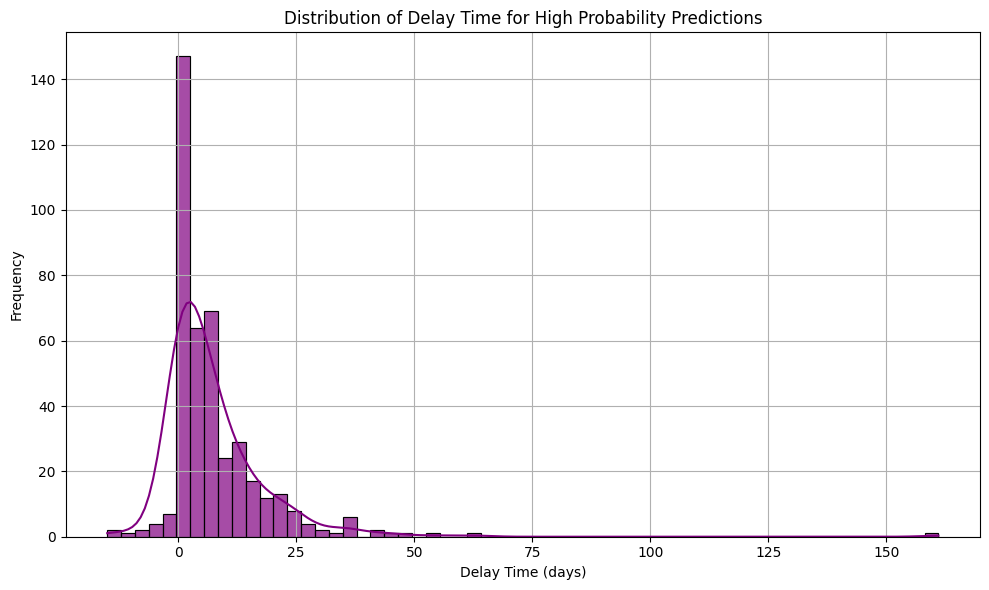

In [13]:
# Filter the dataframe where y_pred is 1
machine_learning_combined = machine_learning
machine_learning_combined.loc[X_test.index, 'y_pred_proba'] = y_pred_proba
machine_learning_combined = machine_learning[machine_learning['y_pred_proba'].notnull()]
# Filter the dataframe where y_pred_proba > 0.5
high_proba_df = machine_learning_combined[machine_learning_combined['y_pred_proba'] > 0.5]

# Plot the distribution of delay_time
plt.figure(figsize=(10, 6))
sns.histplot(high_proba_df['delay_time'], bins=60, kde=True, color='purple', alpha=0.7)
plt.title('Distribution of Delay Time for High Probability Predictions')
plt.xlabel('Delay Time (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

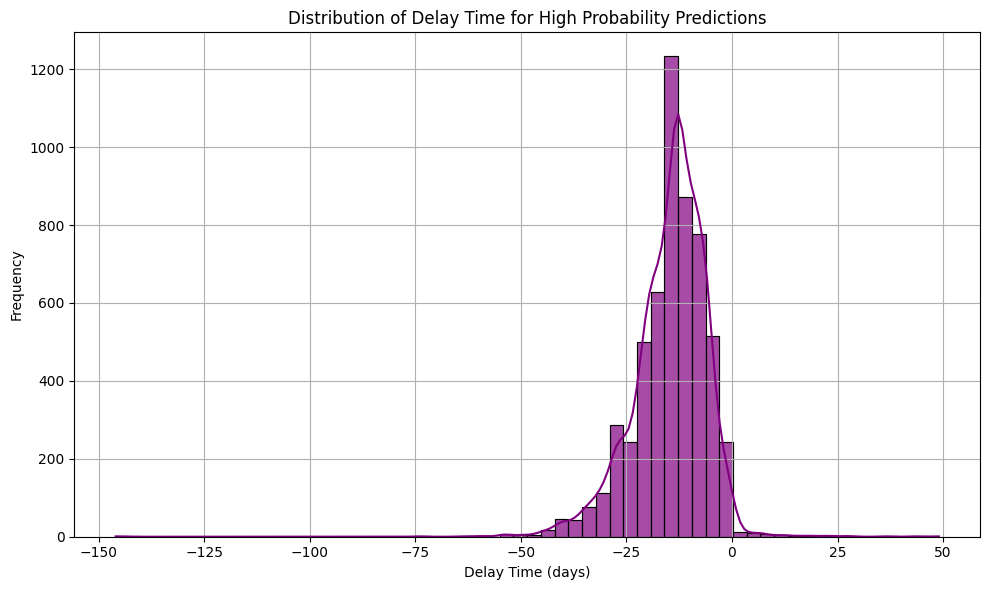

In [14]:
# Filter the dataframe where y_pred is 1
machine_learning_combined = machine_learning
machine_learning_combined.loc[X_test.index, 'y_pred_proba'] = y_pred_proba
machine_learning_combined = machine_learning[machine_learning['y_pred_proba'].notnull()]
# Filter the dataframe where y_pred_proba > 0.5
low_proba_df = machine_learning_combined[machine_learning_combined['y_pred_proba'] < 0.02]

# Plot the distribution of delay_time
plt.figure(figsize=(10, 6))
sns.histplot(low_proba_df['delay_time'], bins=60, kde=True, color='purple', alpha=0.7)
plt.title('Distribution of Delay Time for High Probability Predictions')
plt.xlabel('Delay Time (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [150]:
from sklearn.metrics import roc_curve, auc

machine_learning = pd.read_csv('../data_csv/machine_learning_1.csv')
machine_learning = machine_learning.merge(
    df[['customer_unique_id', 'avg_neighbor_distance_km']],
    on='customer_unique_id',
    how='left'
)
# Create interaction feature: freight value divided by product weight
machine_learning['freight_per_weight'] = machine_learning.apply(
    lambda row: row['freight_value'] / row['total_order_weight'] if row['total_order_weight'] > 0 and pd.notnull(row['total_order_weight']) else np.nan,
    axis=1
)

unique_customer_states = pd.DataFrame(machine_learning['customer_state'].unique(), columns=['unique_customer_states'])

# Define regions and their corresponding states
regions = {
    'North': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Northeast': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Central-West': ['DF', 'GO', 'MT', 'MS'],
    'Southeast': ['ES', 'MG', 'RJ'],
    'South': ['PR', 'RS', 'SC'],
    'Sao-Paulo': ['SP']
}
# Map states to their regions
unique_customer_states['region'] = unique_customer_states['unique_customer_states'].map(
    lambda state: next((region for region, states in regions.items() if state in states), 'Unknown')
)
# Add region information to the machine_learning dataframe
machine_learning['region'] = machine_learning['customer_state'].map(
    lambda state: next((region for region, states in regions.items() if state in states), 'Unknown')
)
# Feature preparation
features = ['unique_seller_count', 'delivery_time_buffer', 'product_count', 'estimate_length','category','freight_value', 'freight_per_weight', 'price', 'distance', 'same_state',  'avg_neighbor_distance_km']
X = pd.get_dummies(machine_learning[features].dropna(), columns=['category'])
y = machine_learning.loc[X.index, 'late']

# Split BEFORE oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Recombine to oversample only on training data
train_df = pd.concat([X_train, y_train], axis=1)
df_majority = train_df[train_df['late'] == 0]
df_minority = train_df[train_df['late'] == 1]

df_minority_oversampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

train_balanced = pd.concat([df_majority, df_minority_oversampled])
X_train = train_balanced.drop('late', axis=1)
y_train = train_balanced['late']

# Train model
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))





Accuracy: 0.9370280302060668

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     21624
           1       0.81      0.24      0.38      1815

    accuracy                           0.94     23439
   macro avg       0.87      0.62      0.67     23439
weighted avg       0.93      0.94      0.92     23439



In [155]:
print("Size of X:", X.shape)

Size of X: (117192, 83)


                     Feature  Importance
7                   distance    0.149933
3            estimate_length    0.136999
5         freight_per_weight    0.129632
6                      price    0.122901
4              freight_value    0.122281
9   avg_neighbor_distance_km    0.107855
1       delivery_time_buffer    0.068775
8                 same_state    0.010867
2              product_count    0.008301
77   category_sports_leisure    0.008015


/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/1280797052.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


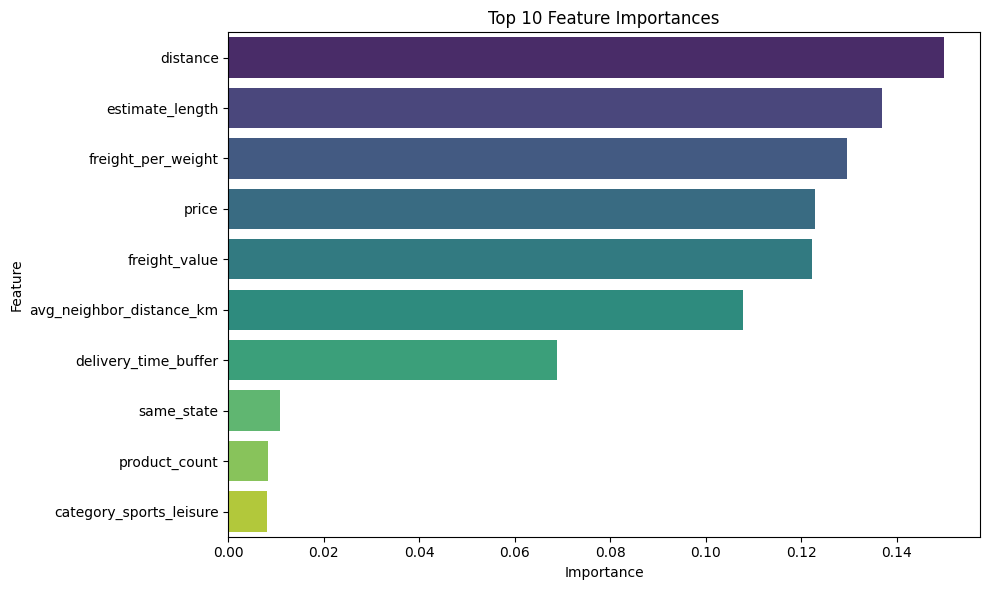

In [111]:
# Feature importance
importances = clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

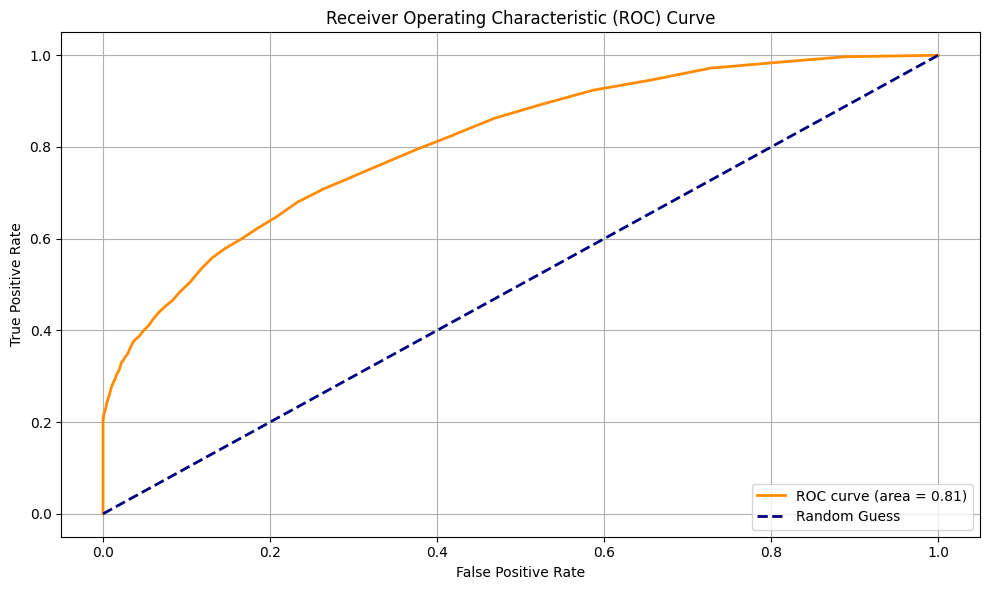

In [112]:



# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

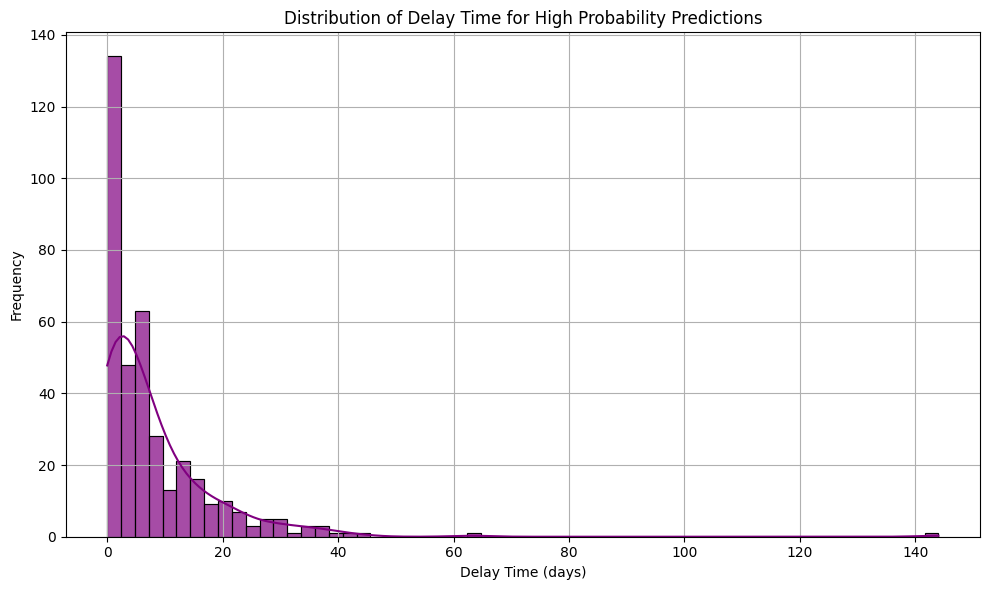

In [151]:
# Filter the dataframe where y_pred is 1
machine_learning_combined = machine_learning
machine_learning_combined.loc[X_test.index, 'y_pred_proba'] = y_pred_proba
machine_learning_combined = machine_learning[machine_learning['y_pred_proba'].notnull()]
# Filter the dataframe where y_pred_proba > 0.5
high_proba_df = machine_learning_combined[machine_learning_combined['y_pred_proba'] >0.9]

# Plot the distribution of delay_time
plt.figure(figsize=(10, 6))
sns.histplot(high_proba_df['delay_time'], bins=60, kde=True, color='purple', alpha=0.7)
plt.title('Distribution of Delay Time for High Probability Predictions')
plt.xlabel('Delay Time (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# need information different delay dates
# for each day: 
# what percentage of late deliveries prevented?
# What happens to median delivery performance?
# Create a new DataFrame to store results



/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/1018263935.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_proba_df['adjusted_delay'] = high_proba_df['delay_time'] - days
/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/1018263935.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_proba_df['adjusted_late'] = high_proba_df['adjusted_delay'] > 0
/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/1018263935.py:9: SettingWithCopyWarning: 
A value is

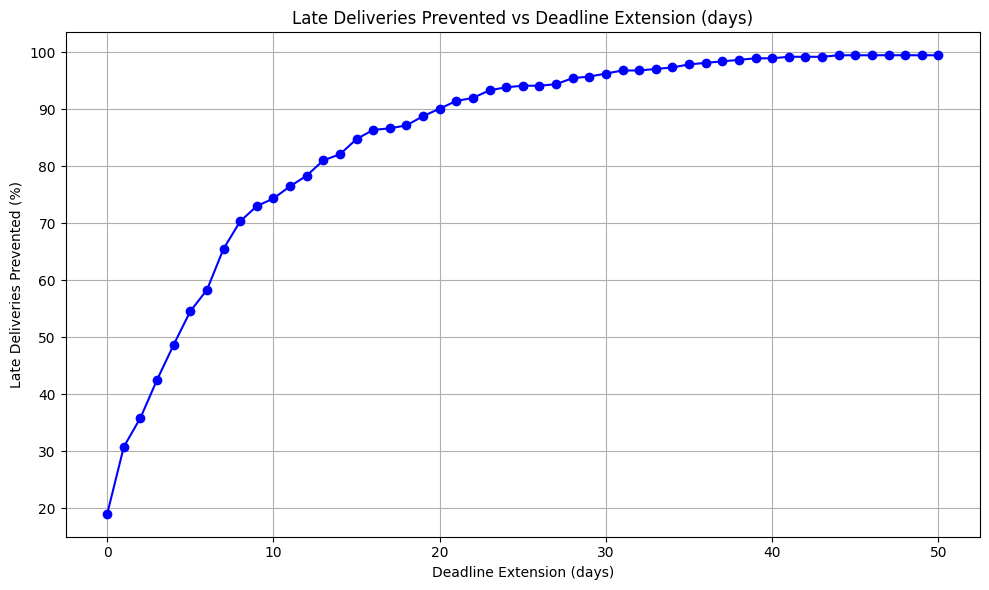

In [154]:
shift_days = range(0, 51)
late_deliveries_prevention = []

for days in shift_days:
    
    # Recalculate the probability of late deliveries
    
    # adjusted delay
    high_proba_df['adjusted_delay'] = high_proba_df['delay_time'] - days
    high_proba_df['adjusted_late'] = high_proba_df['adjusted_delay'] > 0

    # Calculate the percentage of late deliveries prevented
    original_late_count = high_proba_df['late'].sum()
    adjusted_late_count = high_proba_df['adjusted_late'].sum()
    prevented_percentage = ((original_late_count - adjusted_late_count) / original_late_count) * 100
    
    late_deliveries_prevention.append({
        'Shift Days': days,
        'Late Deliveries Prevented (%)': prevented_percentage
    })

# Convert the results into a DataFrame
late_deliveries_prevention_df = pd.DataFrame(late_deliveries_prevention)
late_deliveries_prevention_df.head(50)

plt.figure(figsize=(10, 6))
plt.plot(late_deliveries_prevention_df['Shift Days'], late_deliveries_prevention_df['Late Deliveries Prevented (%)'], marker='o', color='blue')
plt.title('Late Deliveries Prevented vs Deadline Extension (days)')
plt.xlabel('Deadline Extension (days)')
plt.ylabel('Late Deliveries Prevented (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [145]:

high_proba_df['adjusted_delay'] = high_proba_df['delay_time'] + 1
high_proba_df['adjusted_late'] = high_proba_df['adjusted_delay'] > 0
adjusted_late_count = high_proba_df['adjusted_late'].sum()
original_late_count = high_proba_df['late'].sum()
print(original_late_count, adjusted_late_count)
high_proba_df.head()


97 97


/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/4272880344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_proba_df['adjusted_delay'] = high_proba_df['delay_time'] + 1
/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/4272880344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_proba_df['adjusted_late'] = high_proba_df['adjusted_delay'] > 0


,customer_unique_id,delay_time,unique_seller_count,delivery_time_buffer,product_count,total_order_weight,seller_state,customer_state,route,estimate_length,...,distance,category,late,same_state,same_city,avg_neighbor_distance_km,freight_per_weight,y_pred_proba,adjusted_delay,adjusted_late
6584,85189d642c11e7090cb2f72fed68ea42,5,1,6,1,1000.0,SP,DF,SPDF,21,...,596.081499,computers_accessories,1,0,0,0.486040,0.015100,1.00,6,True
6587,85189d642c11e7090cb2f72fed68ea42,5,1,6,1,1000.0,SP,DF,SPDF,21,...,596.081499,computers_accessories,1,0,0,0.486040,0.015100,1.00,6,True
7130,fcb9353836cb5b48b1ac7730e34f1a71,9,1,7,1,7200.0,SP,CE,SPCE,25,...,2318.051611,garden_tools,1,0,0,0.331446,0.002871,1.00,10,True
10732,c9c95b3008a12b91d3597b86d704f5d7,0,1,4,1,8550.0,GO,GO,GOGO,4,...,12.763592,sports_leisure,1,1,0,1.242297,0.001091,0.95,1,True
12334,74fe4e106702770ef728399ce5da503a,0,1,4,1,500.0,SP,GO,SPGO,23,...,816.532796,telephony,1,0,0,0.000000,0.028200,0.94,1,True


/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/259580291.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_learning_combined['delay_percentage'] = (machine_learning_combined['delay_time'] / machine_learning_combined['estimate_length']) * 100


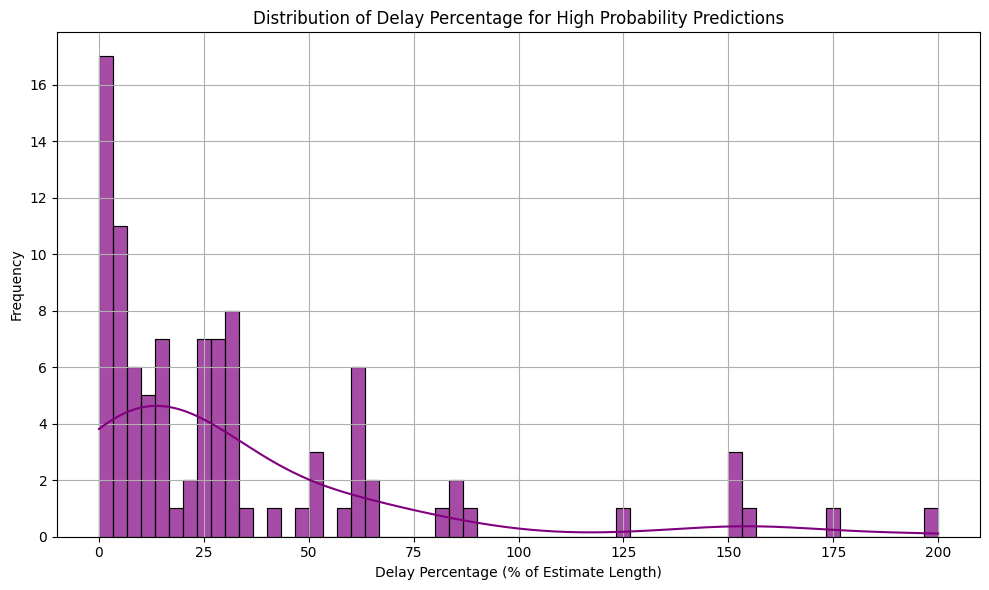

/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/259580291.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_proba_df['shift_days'] = high_proba_df['estimate_length']*(percentage/100)
/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/259580291.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_proba_df['adjusted_delay'] = high_proba_df['delay_time'] - high_proba_df['shift_days']
/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/259580291.py:32: Se

,Shift Percentage,Late Deliveries Prevented (%),avg shift,median shift
0,0,17.525773,0.000000,0.0
1,5,23.711340,1.042268,1.1
2,10,35.051546,2.084536,2.2
3,15,42.268041,3.126804,3.3
4,20,48.453608,4.169072,4.4
5,25,55.670103,5.211340,5.5
6,30,64.948454,6.253608,6.6
7,35,73.195876,7.295876,7.7
8,40,75.257732,8.338144,8.8
9,45,75.257732,9.380412,9.9


In [146]:
# Filter the dataframe where y_pred is 1
machine_learning_combined = machine_learning
machine_learning_combined.loc[X_test.index, 'y_pred_proba'] = y_pred_proba
machine_learning_combined = machine_learning[machine_learning['y_pred_proba'].notnull()]
# Filter the dataframe where y_pred_proba > 0.5
# Calculate delay time as a percentage of estimate length
machine_learning_combined['delay_percentage'] = (machine_learning_combined['delay_time'] / machine_learning_combined['estimate_length']) * 100

# Filter the dataframe where y_pred_proba > 0.9
high_proba_df = machine_learning_combined[machine_learning_combined['y_pred_proba'] > 0.9]

# Plot the distribution of delay_percentage
plt.figure(figsize=(10, 6))
sns.histplot(high_proba_df['delay_percentage'], bins=60, kde=True, color='purple', alpha=0.7)
plt.title('Distribution of Delay Percentage for High Probability Predictions')
plt.xlabel('Delay Percentage (% of Estimate Length)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


shift_percentages = range(0, 200,5)
late_deliveries_prevention = []

for percentage in shift_percentages:
    
    # Recalculate the probability of late deliveries
    high_proba_df['shift_days'] = high_proba_df['estimate_length']*(percentage/100)
    # adjusted delay
    high_proba_df['adjusted_delay'] = high_proba_df['delay_time'] - high_proba_df['shift_days']
    high_proba_df['adjusted_late'] = high_proba_df['adjusted_delay'] > 0

    # Calculate the percentage of late deliveries prevented
    original_late_count = high_proba_df['late'].sum()
    adjusted_late_count = high_proba_df['adjusted_late'].sum()
    prevented_percentage = ((original_late_count - adjusted_late_count) / original_late_count) * 100
    average_increase_days = high_proba_df['shift_days'].mean()
    median_shift = high_proba_df['shift_days'].median()
    
    late_deliveries_prevention.append({
        'Shift Percentage': percentage,
        'Late Deliveries Prevented (%)': prevented_percentage,
        'avg shift': average_increase_days,
        'median shift': median_shift
    })

# Convert the results into a DataFrame
late_deliveries_prevention_df = pd.DataFrame(late_deliveries_prevention)
late_deliveries_prevention_df.head(50)

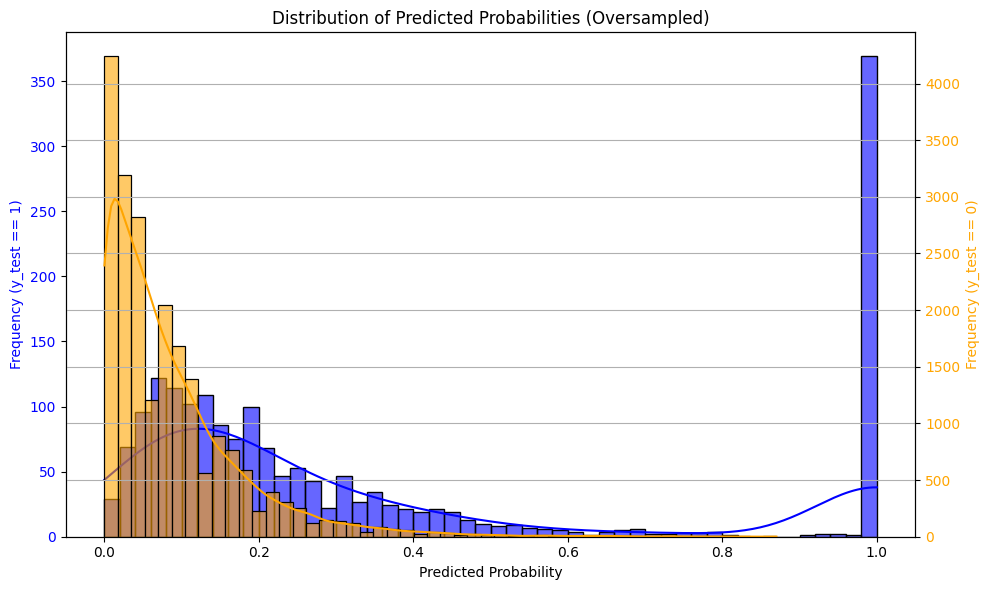

In [104]:
plt.figure(figsize=(10, 6))

# Create the first axis
ax1 = plt.gca()
sns.histplot(y_pred_proba[y_test == 1], bins=50, kde=True, color='blue', alpha=0.6, label='y_test == 1', ax=ax1)
ax1.set_ylabel('Frequency (y_test == 1)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second axis
ax2 = ax1.twinx()
sns.histplot(y_pred_proba[y_test == 0], bins=50, kde=True, color='orange', alpha=0.6, label='y_test == 0', ax=ax2)
ax2.set_ylabel('Frequency (y_test == 0)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add title and labels
plt.title('Distribution of Predicted Probabilities (Oversampled)')
ax1.set_xlabel('Predicted Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

In [158]:
# Filter rows where y_pred_proba is above a threshold
high_proba_indices = y_pred_proba > 0.9
low_proba_indices = y_pred_proba < 0.01
# Count the number of true positives and false positives
true_positives = ((y_test == 1) & high_proba_indices).sum()
false_positives = ((y_test == 0) & high_proba_indices).sum()

true_negatives = ((y_test == 0) & low_proba_indices).sum()
false_negatives = ((y_test == 1) & low_proba_indices).sum()

print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Negatives: {false_negatives}")
false_negative_percentage = (false_negatives / (false_negatives + true_negatives)) * 100
false_positive_percentage = (false_positives / (false_positives + true_positives)) * 100
print(f"Percentage of False Negatives among all negative predictions: {false_negative_percentage:.2f}%")
print(f"Percentage of False Positives among all positive predictions: {false_positive_percentage:.2f}%")

True Positives: 374
False Positives: 0
True Negatives: 2431
False Negatives: 6
Percentage of False Negatives among all negative predictions: 0.25%
Percentage of False Positives among all positive predictions: 0.00%


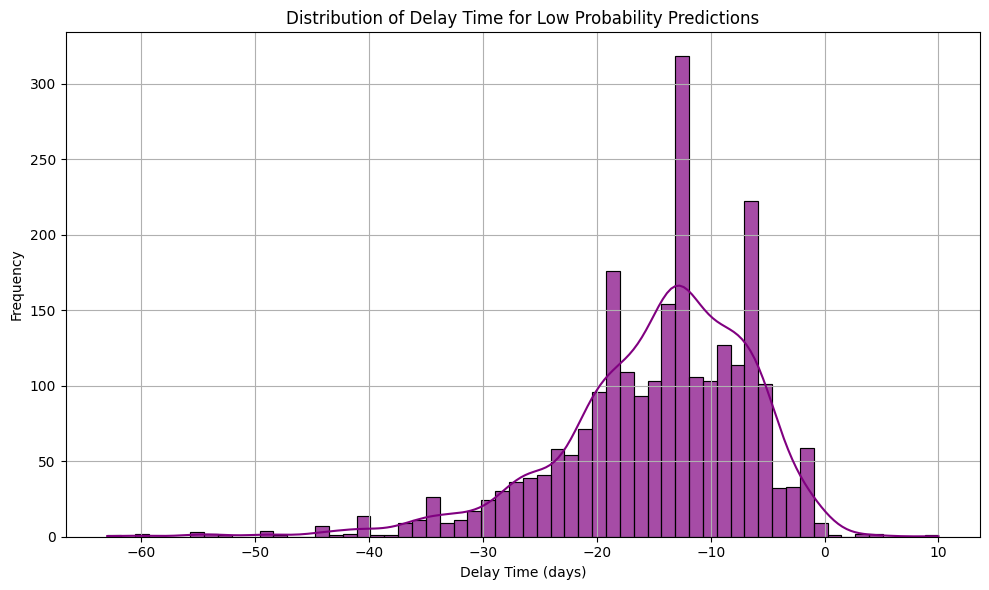

In [161]:
# Filter the dataframe where y_pred is 1
machine_learning_combined = machine_learning
machine_learning_combined.loc[X_test.index, 'y_pred_proba'] = y_pred_proba
machine_learning_combined = machine_learning[machine_learning['y_pred_proba'].notnull()]
# Filter the dataframe where y_pred_proba > 0.5
low_proba_df = machine_learning_combined[machine_learning_combined['y_pred_proba'] <0.01]

# Plot the distribution of delay_time
plt.figure(figsize=(10, 6))
sns.histplot(low_proba_df['delay_time'], bins=60, kde=True, color='purple', alpha=0.7)
plt.title('Distribution of Delay Time for Low Probability Predictions')
plt.xlabel('Delay Time (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# need information different delay dates
# for each day: 
# what percentage of late deliveries prevented?
# What happens to median delivery performance?
# Create a new DataFrame to store results



/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/3275384748.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_proba_df['adjusted_delay'] = low_proba_df['delay_time'] + days
/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/3275384748.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_proba_df['adjusted_late'] = low_proba_df['adjusted_delay'] > 0
/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_65815/3275384748.py:9: SettingWithCopyWarning: 
A value is try

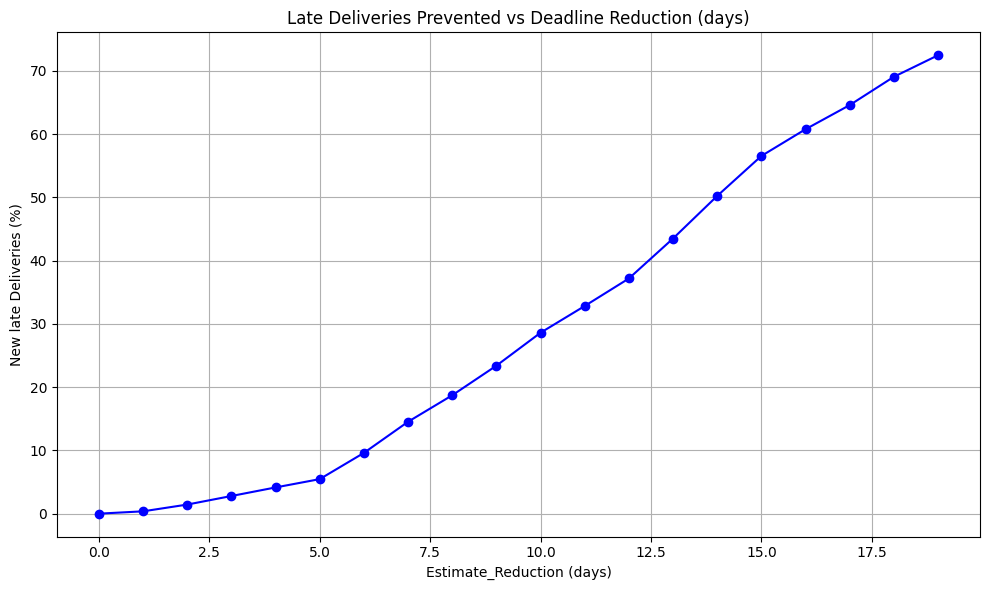

In [165]:
shift_days = range(0, 20)
late_deliveries_prevention = []

for days in shift_days:
    
    # Recalculate the probability of late deliveries
    
    # adjusted delay
    low_proba_df['adjusted_delay'] = low_proba_df['delay_time'] + days
    low_proba_df['adjusted_late'] = low_proba_df['adjusted_delay'] > 0

    # Calculate the percentage of late deliveries prevented
    total_count = len(low_proba_df)
    original_late_count = low_proba_df['late'].sum()
    adjusted_late_count = low_proba_df['adjusted_late'].sum()
    new_late_percentage = ((adjusted_late_count - original_late_count) / total_count) * 100
    
    late_deliveries_prevention.append({
        'Shift Days': days,
        'Late Deliveries Prevented (%)': new_late_percentage
    })

# Convert the results into a DataFrame
late_deliveries_prevention_df = pd.DataFrame(late_deliveries_prevention)
late_deliveries_prevention_df.head(50)

plt.figure(figsize=(10, 6))
plt.plot(late_deliveries_prevention_df['Shift Days'], late_deliveries_prevention_df['Late Deliveries Prevented (%)'], marker='o', color='blue')
plt.title('Late Deliveries Prevented vs Deadline Reduction (days)')
plt.xlabel('Estimate_Reduction (days)')
plt.ylabel('New late Deliveries (%)')
plt.grid(True)
plt.tight_layout()
plt.show()